# Bibliography data

## Import libraries and styles for data visualization

In [177]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re
import ast

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

## High-level descriptive information

Load the dataset:

In [178]:
df = pd.read_csv('../data/raw/bibliografia.csv', delimiter='|', encoding='ISO-8859-1')

### Data sparsity

Check NULL data:

<Axes: >

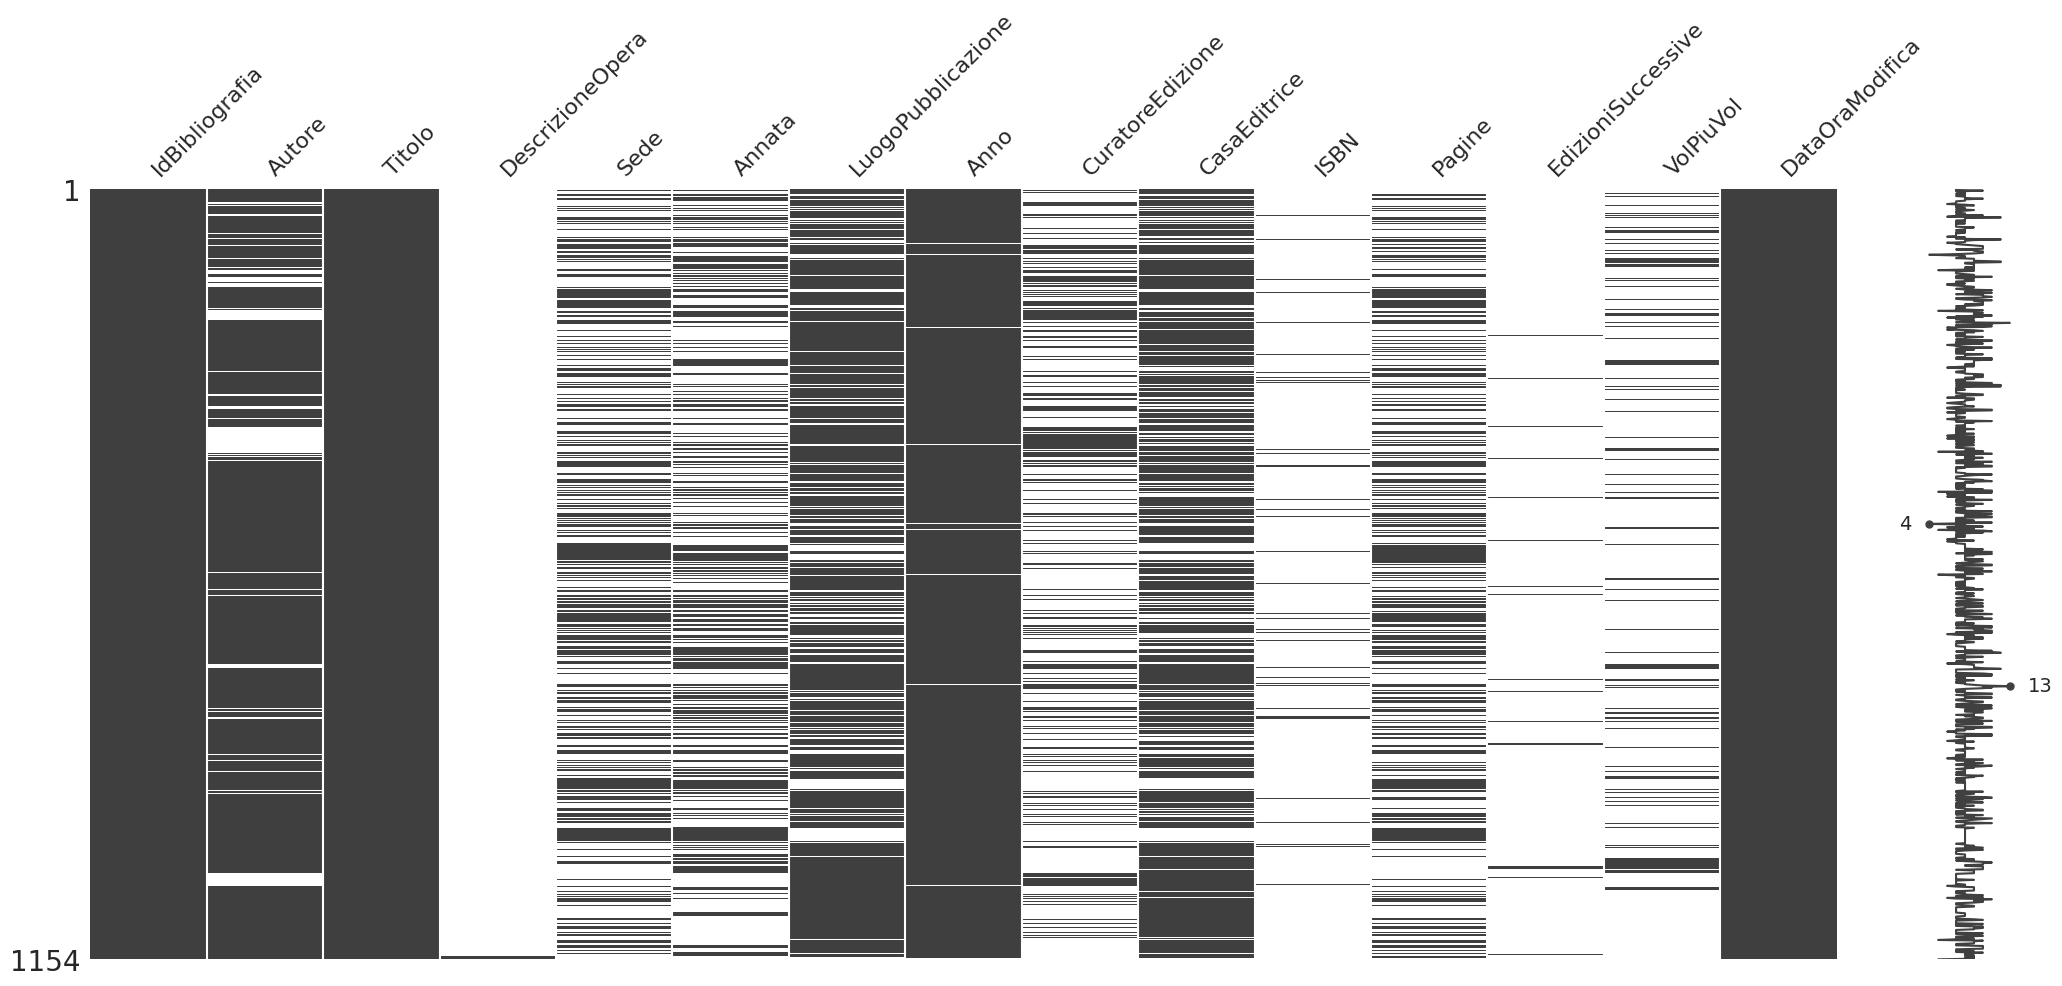

In [179]:
msno.matrix(df)

In addition to NULL data, another problem needs to be addressed, namely the incomplete names of both the authors and the editors:

In [180]:
df[['Autore', 'CuratoreEdizione', 'CasaEditrice']].loc[[2]]

,Autore,CuratoreEdizione,CasaEditrice
2,Zambotti B.,Pardi G.,Zanichelli N.


We will try to solve part of the problem by leveraging Google Books API to integrate some of the data we have with external information. The API response will have a specific structure that unfortunately does not include neither the editor's nor the publisher's information, thus we will focus on the author (`Autore`) as well as other information we can glean from the API response, such as the identifier (`ISBN`) and the page count (`Pagine`).

Count the number of incomplete author names, the number of existing identifiers and the number of existing page counts:

In [181]:
author_counts_before = df["Autore"].str.endswith(".", na=False).sum()
print(author_counts_before)

970


In [182]:
identifier_counts_before = df["ISBN"].notna().sum()
print(identifier_counts_before)

53


In [183]:
pages_counts_before = df['Pagine'].notna().sum()
print(pages_counts_before)

471


## Data integration

Functions to send a query to the Google Books API endpoint, get specific data from the JSON response and add those data in new columns in the dataframe. In our case, the query search term is the title string (`Titolo`):

In [184]:
def search_for_books(search_term, max_results = 1):
    if not search_term:
        return []
    if not isinstance(max_results, int):
        max_results = 3
    API_ENDPOINT = 'https://www.googleapis.com/books/v1/volumes'
    params = {
        'q': search_term,
        'maxResults': max_results
    }
    try:
        res = requests.get(API_ENDPOINT, params=params)
        return res.json()
    except requests.exceptions.RequestException as e:
        return e

In [185]:
def add_data(df, column_name, field):
    def get_book_data(title, field):
        title = title.lower()
        title = re.sub(r'[.:;,?!—\(\)\[\]\']\s|\s[.:;,?!—\(\)\[\]\']|[\s.:;,?!—\(\)\[\]\']', '+', title)
        try:
            api_data = search_for_books(title)
            if 'items' in api_data and api_data['items']:
                if field == 'authors':
                    return api_data['items'][0]['volumeInfo']['authors']
                elif field == 'identifiers':
                    return api_data['items'][0]['volumeInfo']['industryIdentifiers']
                elif field == 'pageCount':
                    return api_data['items'][0]['volumeInfo']['pageCount']
            else:
                return None
        except Exception as e:
            return None
    df[column_name] = df['Titolo'].apply(lambda title: get_book_data(title, field))
    return df

Run the functions to add complete authors' names, new identifiers and new page counts:

In [186]:
df = add_data(df, 'new_authors', 'authors')

In [187]:
df = add_data(df, 'new_identifier', 'identifiers')

In [188]:
df = add_data(df, 'new_pagecount', 'pageCount')

For the newly added `new_authors` and `new_identifier` columns, we need to convert their cells' datatypes from `str` to `list`:

In [189]:
def convert_to_list(value):
    if isinstance(value, (list, np.ndarray, pd.Series)):
        if pd.isna(value).all():
            return []
        return list(value)
    if pd.isna(value):
        return []
    if isinstance(value, str):
        try:
            parsed_value = ast.literal_eval(value)
            return parsed_value if isinstance(parsed_value, list) else [parsed_value]
        except (ValueError, SyntaxError):
            return []
    return value

df["new_authors"] = df["new_authors"].apply(convert_to_list)
df["new_identifier"] = df["new_identifier"].apply(convert_to_list)

Funcion that reconciles the existing author names in `Autore` with the newly added complete names in `new_authors`, on the basis of the family name:

In [190]:
def reconcile_authors(row):
    try:
        family_name = row["Autore"].split()[0]
        for author in row["new_authors"]:
            if family_name in author:
                row["author"] = "; ".join(row["new_authors"])
        return row
    except Exception as e:
        return row

df = df.apply(reconcile_authors, axis=1)

If the author is the same (and thus, realistically, we are talking about the same book), also add the respective new identifier(s) found in `new_identifier` and the new page counts found in `new_pagecount`:

In [191]:
def reconcile_identifiers(row):
    try:
        if not pd.isna(row["author"]):
            identifiers = []
            for identifier_entry in row["new_identifier"]:
                identifier_value = identifier_entry["identifier"]
                if not identifier_value[0].isalpha():
                    identifier_value = f"ISBN:{identifier_value}"
                identifiers.append(identifier_value)
            row["identifier"] = "; ".join(identifiers)
        return row
    except Exception as e:
        return row

df = df.apply(reconcile_identifiers, axis=1)

In [192]:
def reconcile_pagecounts(row):
    try:
        if not pd.isna(row["author"]):
            row['pageCount'] = row['new_pagecount']
        return row
    except Exception as e:
        return row

df = df.apply(reconcile_pagecounts, axis=1)

Integrate the old columns with the new ones:

In [193]:
df['author'] = df['author'].fillna(df['Autore'])

In [194]:
df['identifier'] = df['identifier'].fillna(df['ISBN'])

In [195]:
df['pageCount'] = df['pageCount'].fillna(df['Pagine'])

Keep only a selcted set of columns, change their names and set the `id` as the index of the dataframe:

In [196]:
keep_cols = ['IdBibliografia', 'Titolo', 'author', 'identifier', 'Anno',
             'LuogoPubblicazione', 'CasaEditrice', 'CuratoreEdizione', 'Annata',
             'Sede', 'pageCount']
rename_cols = {'IdBibliografia': 'id',
        'Titolo': 'title',
        'Anno': 'pubYear',
        'LuogoPubblicazione': 'pubPlace',
        'CasaEditrice': 'publisher',
        'CuratoreEdizione': 'editor',
        'Annata': 'issue',
        'Sede': 'shelfMark'}

df = df[keep_cols].rename(columns=rename_cols)

In [197]:
df = df.set_index('id')
df

,title,author,identifier,pubYear,pubPlace,publisher,editor,issue,shelfMark,pageCount
id,,,,,,,,,,
1,Alcuni cenni storici di Cusercoli: omaggio al ...,Ricci L.,NaN,1904,Castelplanio,Premiata Tipografia Editrice Romagnoli,NaN,NaN,NaN,NaN
2,Il castello e la chiesa di Polenta nella provi...,Raffaello Zampa,OCLC:1001173233,1891,Milano,Premiata Tipografia e Litografia degli Ingegneri,NaN,NaN,NaN,NaN
3,Diario Ferrarese dell'anno 1476 sino al 1504: ...,Bernardino Zambotti,OCLC:174376226,1934-1937,Bologna,Zanichelli N.,Pardi G.,XXIV/VII/II,RR.II.SS.,0.0
4,"Fiumana, l'abbazia, il paese e la parrocchia",Franco Zaghini,OCLC:79626048,1996,Forlì,Valbonesi Tipografia,NaN,NaN,NaN,204.0
5,Meldola un castello una città: notizie storich...,Giacomo Zaccaria,OCLC:963265524,1969,Forlì,Raffaelli Tipografia,NaN,NaN,NaN,50.0
...,...,...,...,...,...,...,...,...,...,...
1186,Le mura di Reggio Emilia - L'età contemporanea,Baricchi W.,NaN,2007,Reggio Emilia,Grafitalia,NaN,NaN,NaN,175
1187,Reggio e le sue mura in età comunale e princip...,Gamberini A.,NaN,2007,Reggio Emilia,Grafitalia,NaN,NaN,NaN,175
1188,Le mura inesistenti? Il perimetro urbano della...,Gelichi S. - Curina R.,NaN,2007,NaN,Grafitalia,NaN,NaN,NaN,175


### Results

Incomplete authors' names have been reduced from 970 down to 548:

[Text(0, 0, '970'), Text(0, 0, '566')]

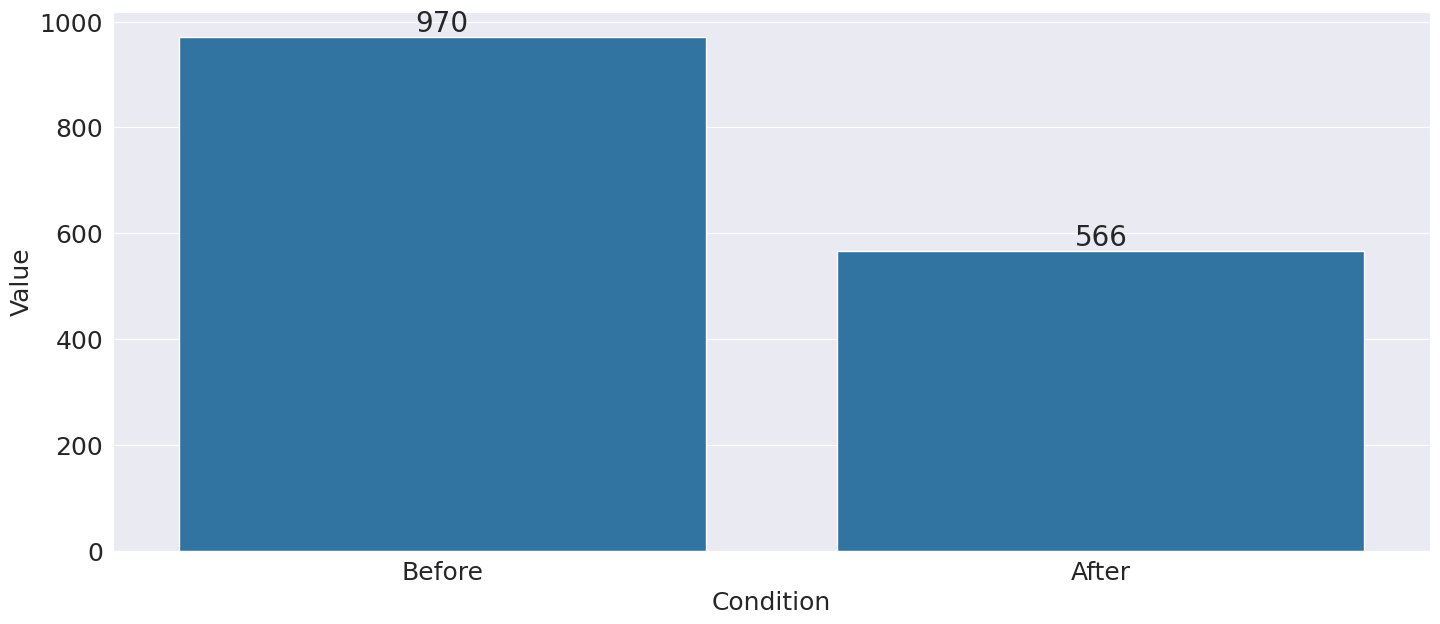

In [198]:
author_counts_after = df["author"].str.endswith(".", na=False).sum()
data = pd.DataFrame({"Condition": ["Before", "After"], "Value": [author_counts_before, author_counts_after]})
ax = sns.barplot(x="Condition", y="Value", data=data)
ax.bar_label(ax.containers[0], fontsize=20)

New identifiers in addition to ISBN have been added, thus increasing them from 53 up to 468:

[Text(0, 0, '53'), Text(0, 0, '450')]

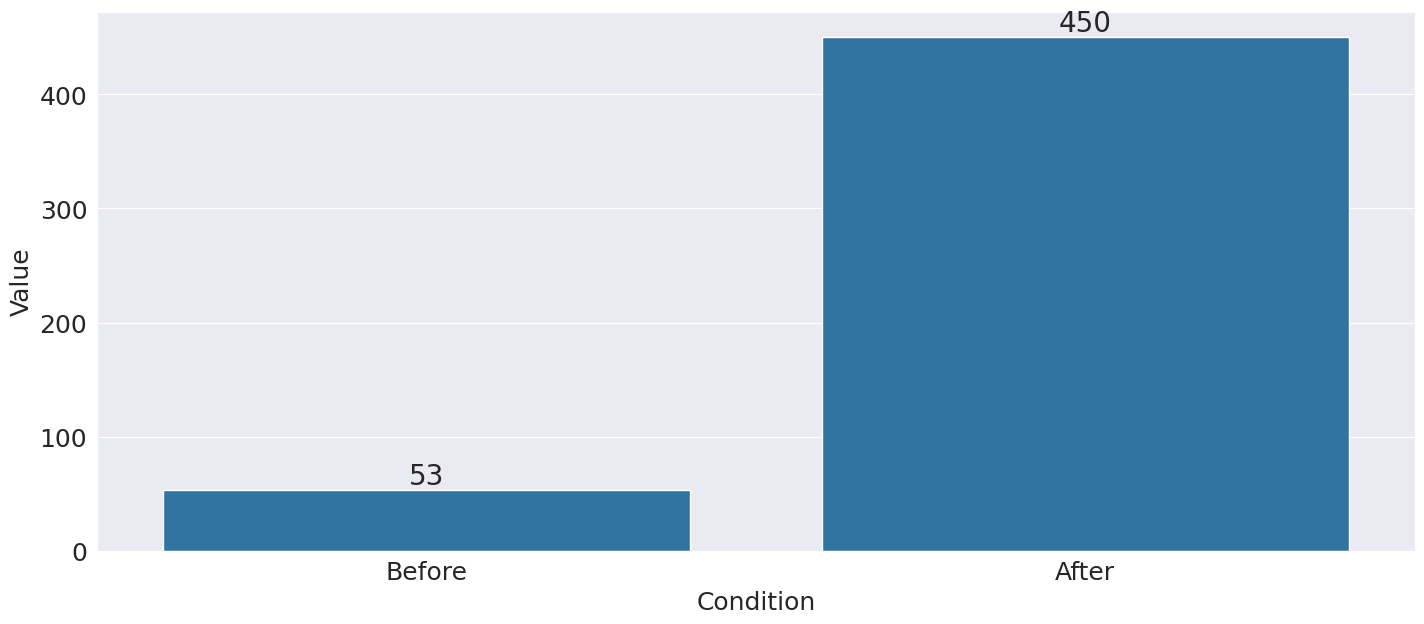

In [199]:
identifier_counts_after = df["identifier"].notna().sum()
data = pd.DataFrame({"Condition": ["Before", "After"], "Value": [identifier_counts_before, identifier_counts_after]})
ax = sns.barplot(x="Condition", y="Value", data=data)
ax.bar_label(ax.containers[0], fontsize=20)

Updated page counts have been added, thus increasing from 471 up to 779:

[Text(0, 0, '471'), Text(0, 0, '787')]

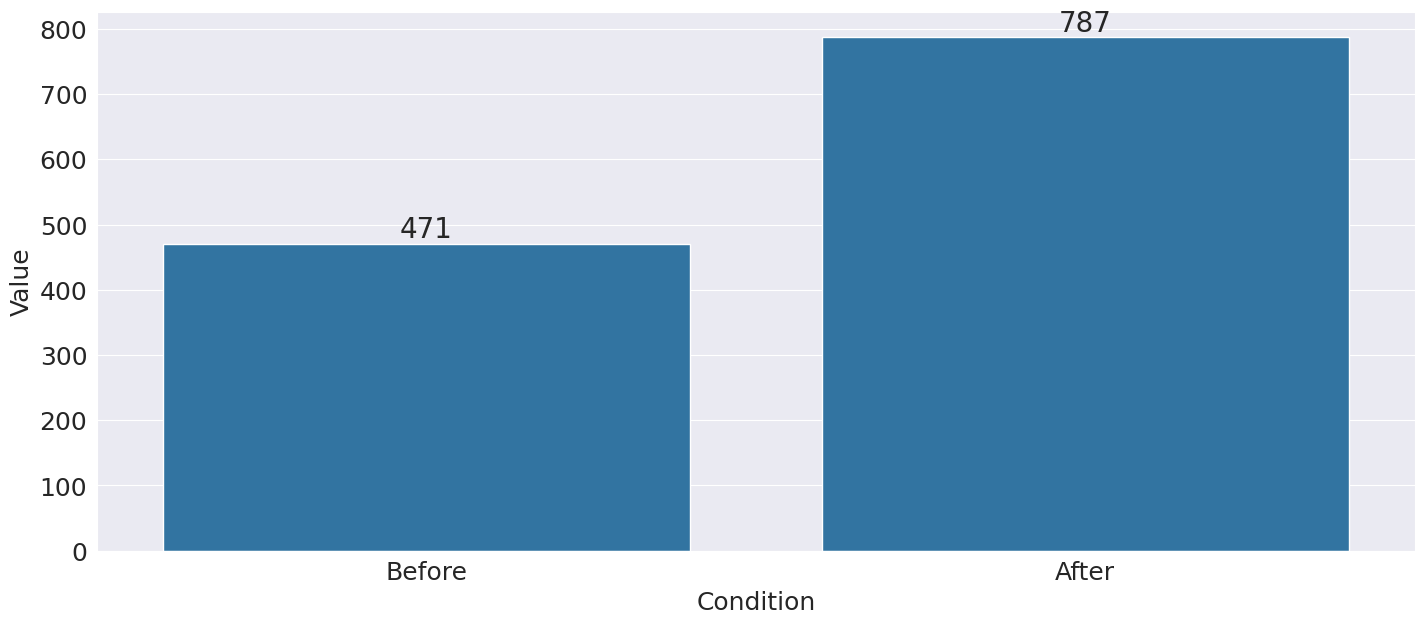

In [200]:
page_counts_after = df["pageCount"].notna().sum()
data = pd.DataFrame({"Condition": ["Before", "After"], "Value": [pages_counts_before, page_counts_after]})
ax = sns.barplot(x="Condition", y="Value", data=data)
ax.bar_label(ax.containers[0], fontsize=20)

Generate `bibliography.csv` in `../data/output`:

In [201]:
df.to_csv('../data/output/bibliography.csv', index=False)